In [1]:
!gdown -q 1p2g68kxvXnez9yc2nhD6XJ0aGTx2tyRX # for video
!gdown -q 1Ktw1z2m8pXYwhJdsKHWmfe5hpCmbl86C # for replacement car

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [15]:
def get_video_info(cap):
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return fps, width, height, frame_count

In [16]:
def draw_polygon(frame, points, color=(0, 255, 0), thickness=2):
    pts = points.astype(np.int32).reshape((-1, 1, 2))
    cv2.polylines(frame, [pts], True, color, thickness)
    return frame

In [17]:
sift = cv2.SIFT_create()

def extract_roi_template(frame, corners):
    x, y, w, h = cv2.boundingRect(corners.astype(np.int32))

    padding = 20
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(frame.shape[1] - x, w + 2*padding)
    h = min(frame.shape[0] - y, h + 2*padding)

    roi = frame[y:y+h, x:x+w]
    mask = np.zeros((h, w), dtype=np.uint8)
    adjusted_corners = corners - np.array([x, y])
    cv2.fillPoly(mask, [adjusted_corners.astype(np.int32)], 255)

    return roi, mask, (x, y)

def match_features(img1, img2, mask1=None, ratio_thresh=0.75):
    kp1, des1 = sift.detectAndCompute(img1, mask1)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if des1 is None or des2 is None or len(des1) < 4:
        return None, None

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)

    if len(good_matches) < 4:
        return None, None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    return src_pts, dst_pts

def update_corners(prev_corners, prev_frame, curr_frame):
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY) if len(prev_frame.shape) == 3 else prev_frame
    curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY) if len(curr_frame.shape) == 3 else curr_frame

    prev_roi, prev_mask, roi_offset = extract_roi_template(prev_gray, prev_corners)

    search_padding = 150
    x_min = max(0, roi_offset[0] - search_padding)
    y_min = max(0, roi_offset[1] - search_padding)
    x_max = min(curr_gray.shape[1], roi_offset[0] + prev_roi.shape[1] + search_padding)
    y_max = min(curr_gray.shape[0], roi_offset[1] + prev_roi.shape[0] + search_padding)

    curr_search_region = curr_gray[y_min:y_max, x_min:x_max]

    src_pts, dst_pts = match_features(prev_roi, curr_search_region, mask1=prev_mask)

    if src_pts is None:
        return prev_corners

    dst_pts += np.array([x_min, y_min])
    src_pts += np.array(roi_offset)

    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if H is not None:
        corners_reshaped = prev_corners.reshape(-1, 1, 2)
        new_corners = cv2.perspectiveTransform(corners_reshaped, H)
        new_corners = new_corners.reshape(-1, 2).astype(np.float32)

        if (np.all(new_corners >= 0) and
            np.all(new_corners[:, 0] < curr_frame.shape[1]) and
            np.all(new_corners[:, 1] < curr_frame.shape[0])):
            return new_corners

    return prev_corners

In [18]:
def prepare_replacement_image(car_img):
    if car_img.shape[2] == 4:
        alpha = car_img[:, :, 3] / 255.0
        car_rgb = car_img[:, :, :3]
        return car_rgb, alpha
    else:
        alpha = np.ones((car_img.shape[0], car_img.shape[1]))
        return car_img, alpha

In [19]:
def create_blend_mask(corners, frame_shape):
    mask = np.zeros(frame_shape[:2], dtype=np.float32)
    pts = corners.astype(np.int32)
    cv2.fillPoly(mask, [pts], 1.0)
    mask = gaussian_filter(mask, sigma=5)
    return mask

In [20]:
def replace_car_in_frame(frame, car_corners, replacement_car, replacement_alpha):
    h, w = replacement_car.shape[:2]
    src_corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]])

    H, _ = cv2.findHomography(src_corners, car_corners)
    if H is None:
        return frame

    warped = cv2.warpPerspective(replacement_car, H, (frame.shape[1], frame.shape[0]))
    warped_alpha = cv2.warpPerspective(
        (replacement_alpha * 255).astype(np.uint8), H,
        (frame.shape[1], frame.shape[0])
    ) / 255.0

    blend_mask = create_blend_mask(car_corners, frame.shape)
    blend_mask = np.minimum(blend_mask, warped_alpha)

    # Poisson blending
    M = cv2.moments(car_corners.astype(np.int32))
    if M["m00"] != 0:
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
    else:
        center = (int(np.mean(car_corners[:, 0])), int(np.mean(car_corners[:, 1])))

    binary_mask = (blend_mask * 255).astype(np.uint8)
    binary_mask = cv2.threshold(binary_mask, 10, 255, cv2.THRESH_BINARY)[1]

    try:
        result = cv2.seamlessClone(warped, frame, binary_mask, center, cv2.MIXED_CLONE)
    except:
        mask_3ch = np.stack([blend_mask] * 3, axis=2)
        result = warped * mask_3ch + frame * (1 - mask_3ch)
        result = result.astype(np.uint8)

    return result

def process_video(cap, output_path, replacement_car_img, initial_corners):
    fps, width, height, frame_count = get_video_info(cap)
    print(f"Video properties: {width}x{height} @ {fps}fps, {frame_count} frames")

    replacement_car, replacement_alpha = prepare_replacement_image(replacement_car_img)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    ret, first_frame = cap.read()
    if not ret:
        raise ValueError("Cannot read first frame")

    car_corners = initial_corners

    # Visualize initial selection
    preview = first_frame.copy()
    preview = draw_polygon(preview, car_corners, (0, 255, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(preview, cv2.COLOR_BGR2RGB))
    plt.title("Initial Car Region Selection")
    plt.axis('off')
    plt.show()

    result_frame = replace_car_in_frame(
        first_frame, car_corners, replacement_car, replacement_alpha
    )
    out.write(result_frame)

    prev_frame = first_frame.copy()
    frame_idx = 1

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Update tracking
        car_corners = update_corners(car_corners, prev_frame, frame)

        # Replace car
        result_frame = replace_car_in_frame(
            frame, car_corners, replacement_car, replacement_alpha
        )

        out.write(result_frame)
        prev_frame = frame.copy()
        frame_idx += 1

        if frame_idx % 30 == 0:
            print(f"Processed {frame_idx}/{frame_count} frames")

    cap.release()
    out.release()
    print(f"Video saved to: {output_path}")

    return output_path

Video properties: 1280x720 @ 23fps, 409 frames


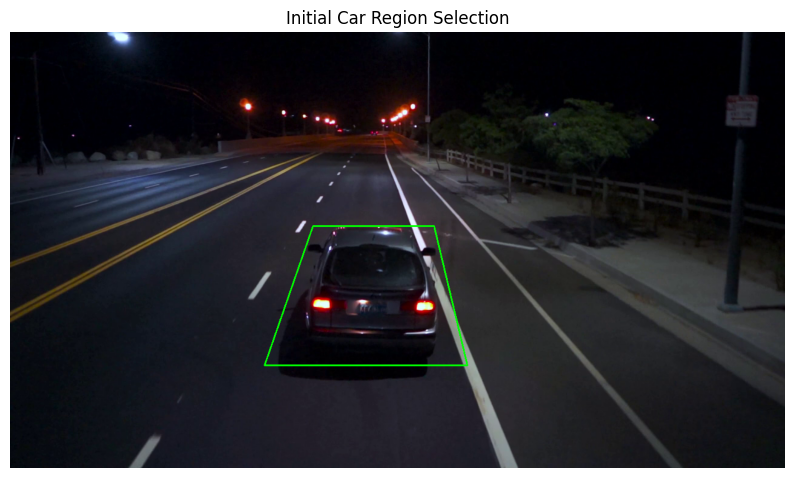

Processed 30/409 frames
Processed 60/409 frames
Processed 90/409 frames
Processed 120/409 frames
Processed 150/409 frames
Processed 180/409 frames
Processed 210/409 frames
Processed 240/409 frames
Processed 270/409 frames
Processed 300/409 frames
Processed 330/409 frames
Processed 360/409 frames
Processed 390/409 frames
Video saved to: output.mp4


'output.mp4'

In [21]:
initial_corners = np.float32([
  [500, 320],   # top-left
  [700, 320],   # top-right
  [755, 550],   # bottom-right
  [420, 550]    # bottom-left
])

cap = cv2.VideoCapture("Car Driving Over Bridge At Night Royalty Free Stock Aerial Drone Footage..mp4")
replacement_car = cv2.imread("car.png", cv2.IMREAD_UNCHANGED)
output_video = "output.mp4"

process_video(
  cap,
  output_video,
  replacement_car,
  initial_corners=initial_corners
)